In [1]:
import os
os.chdir("/raid/dataset_CDMC/Task2/Benchmark_kaggle")

In [2]:
import time,array
import imageio,cv2
# from tqdm import tqdm_eanotebook as tqdm
import codecs
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.patheffects as PathEffects

In [3]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pdzi
import numpy as np
import zipfile
from math import log
from tensorflow.keras.preprocessing.image import array_to_img
from sklearn.utils import shuffle
import math
from tqdm import tqdm
import gc
import tensorflow as tf
import warnings
import csv
import py7zr
warnings.filterwarnings('ignore')
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices([gpus[0],gpus[1],gpus[2],gpus[3]], 'GPU') # gpus[번호바꿔서 사용 0-3번 가능]# %matplotlib inline

In [4]:
def output_class(x):
    output = np.argmax(x)
    if output == 1:
        return 'Ramnit'
    elif output == 2:
        return 'Lollipop'
    elif output == 3:
        return 'Kelihos_ver3'
    elif output == 4:
        return 'Vundo'
    elif output == 5:
        return 'Simda'
    elif output == 6:
        return 'Tracur'
    elif output == 7:
        return 'Kelihos_ver1'
    elif output == 8:
        return 'Obfuscator.ACY'
    elif output == 9:
        return 'Gatak'
    else:
        print("label error!")

### Create a dataset

In [5]:
import pandas as pd
train = pd.read_csv('./malware-classification/trainLabels.csv')
train.head()

Id  Class
0  01kcPWA9K2BOxQeS5Rju      1
1  04EjIdbPV5e1XroFOpiN      1
2  05EeG39MTRrI6VY21DPd      1
3  05rJTUWYAKNegBk2wE8X      1
4  0AnoOZDNbPXIr2MRBSCJ      1

In [6]:
class_names = ['None',
'Ramnit',
'Lollipop',
'Kelihos_ver3',
'Vundo',
'Simda',
'Tracur',
'Kelihos_ver1',
'Obfuscator.ACY',
'Gatak']

In [7]:
train['Class'].value_counts()

3    2942
2    2478
1    1541
8    1228
9    1013
6     751
4     475
7     398
5      42
Name: Class, dtype: int64

In [8]:
train['Class'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

### Load npy file

In [9]:
train_np = np.load('./train_np.npy')
val_np  = np.load('./val_np.npy')
train_label  = np.load('./train_label.npy')
val_label = np.load('./val_label.npy')
# train_np = train_np[:,:,:,0]
# val_np = val_np[:,:,:,0]
train_np = (np.concatenate([train_np,train_np,train_np], axis=3))
val_np = (np.concatenate([val_np,val_np,val_np], axis=3))
train_np.shape, train_label.shape, val_np.shape, val_label.shape

((9781, 224, 224, 3), (9781, 10), (1087, 224, 224, 3), (1087, 10))

In [10]:
# from skimage.transform import resize
# train_np = resize(train_np,(train_np.shape[0], 64,128))
# val_np = resize(val_np,(val_np.shape[0],64,128))
# train_np.shape, train_label.shape, val_np.shape, val_label.shape

### image preprocessing

In [11]:
## defind hyperparameters
BATCH_SIZE = 224
IMG_SIZE = 224

### Convert the data into Tensorflow Dataset objects

In [12]:
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((train_np, train_label))
    .shuffle(1024)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((train_np, train_label))
    .shuffle(1024)
)

train_ds_simple = tf.data.Dataset.from_tensor_slices((train_np, train_label))

test_ds = tf.data.Dataset.from_tensor_slices((val_np, val_label))

train_ds_simple = (train_ds_simple.batch(BATCH_SIZE))

# Combine two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds = (test_ds.batch(BATCH_SIZE))

### Define the Cutmix data augmentation function

In [13]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two
    alpha = [0.25]
    beta = [0.25]
    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

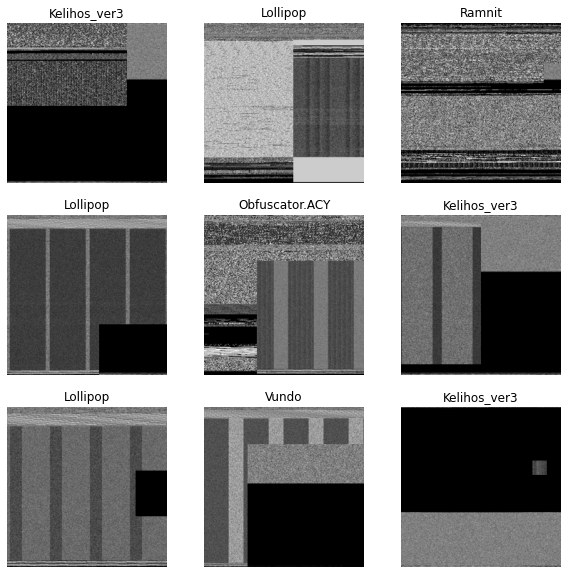

In [14]:
# Create the new dataset using our `cutmix` utility
train_ds_cmu = (
    train_ds.shuffle(1024).map(cutmix)
    .batch(BATCH_SIZE)
)

# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

### Create a model 

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [16]:
def ResNet101V2(input_shape=(None, None, 3), dropout_rate=0.5):
    backbone = tf.keras.applications.ResNet101V2(weights=None, include_top=False, input_shape=input_shape)
    h = tf.keras.layers.Flatten()(backbone.output)
    h = tf.keras.layers.Dropout(dropout_rate)(h)
    h = tf.keras.layers.Dense(units=1024, activation="relu")(h)
    h = tf.keras.layers.Dropout(dropout_rate)(h)
    h = tf.keras.layers.Dense(units=256, activation="relu")(h)   
    output = tf.keras.layers.Dense(10, activation='softmax')(h)
    
    model = tf.keras.Model(backbone.input, output, name="ResNet101V2")
    return model

In [17]:
dropout_rate = 0.5
weights = 'imagenet'
learning_rate = 1e-5
EPOCHS = 150
dropout_rate = 0.1
input_shape= (224,224,3)
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2","/gpu:3"])
with mirrored_strategy.scope():
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model = ResNet101V2(input_shape,  dropout_rate=dropout_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

In [18]:
model.summary()

Model: "ResNet101V2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [19]:
hist = model.fit(train_ds_cmu, validation_data=test_ds, epochs=EPOCHS, callbacks=[es])

Epoch 1/150
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 348 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 348 all-reduces with algorithm = nccl, num_packs = 1
44/44 [==============================] - 29s 651ms/step - loss: 1.5260 - accuracy: 0.5304 - val_loss: 2.1067 - val_accuracy: 0.3827
Epoch 2/150
44/44 [==============================] - 17s 377ms/step - loss: 1.2063 - accuracy: 0.6512 - val_loss: 2.1750 - val_accuracy: 0.1555
Epoch 3/150
44/44 [==============================] - 16s 374ms/step - loss: 1.1133 - accuracy: 0.6953 - val_loss: 2.3916 - val_accuracy: 0.1509
Epoch 4/150
44/44 [==============================] - 17s 376ms/step - loss: 1.0418 - accuracy: 0.7251 - val_loss: 2.5939 - val_accuracy: 0.1720
Epoch 5/150
44/44 [==============================] - 17s 376ms/step - loss: 0.9972 - accuracy: 0.7463 - val_loss: 2.6085 - val_accuracy: 0.1555
Epoch 6/150
44/44 [=====

44/44 [==============================] - 17s 394ms/step - loss: 0.6020 - accuracy: 0.8889 - val_loss: 0.1679 - val_accuracy: 0.9595
Epoch 55/150
44/44 [==============================] - 16s 375ms/step - loss: 0.6066 - accuracy: 0.8850 - val_loss: 0.1690 - val_accuracy: 0.9586
Epoch 56/150
44/44 [==============================] - 17s 378ms/step - loss: 0.6085 - accuracy: 0.8811 - val_loss: 0.1772 - val_accuracy: 0.9558
Epoch 57/150
44/44 [==============================] - 17s 376ms/step - loss: 0.5925 - accuracy: 0.8827 - val_loss: 0.1701 - val_accuracy: 0.9540
Epoch 58/150
44/44 [==============================] - 17s 393ms/step - loss: 0.5925 - accuracy: 0.8850 - val_loss: 0.1660 - val_accuracy: 0.9568
Epoch 59/150
44/44 [==============================] - 17s 375ms/step - loss: 0.5891 - accuracy: 0.8832 - val_loss: 0.1673 - val_accuracy: 0.9577
Epoch 60/150
44/44 [==============================] - 17s 375ms/step - loss: 0.5932 - accuracy: 0.8805 - val_loss: 0.1703 - val_accuracy: 0.959

44/44 [==============================] - 17s 376ms/step - loss: 0.5267 - accuracy: 0.8933 - val_loss: 0.1388 - val_accuracy: 0.9715
Epoch 111/150
44/44 [==============================] - 18s 403ms/step - loss: 0.5197 - accuracy: 0.8993 - val_loss: 0.1355 - val_accuracy: 0.9678


In [20]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

5/5 [==============================] - 0s 88ms/step - loss: 0.1337 - accuracy: 0.9696
Test accuracy: 96.96%


### Train the model using the original non-augmented dataset

In [22]:
dropout_rate = 0.5
weights = 'imagenet'
learning_rate = 1e-5
EPOCHS = 150
dropout_rate = 0.1
input_shape= (224,224,3)
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2","/gpu:3"])
with mirrored_strategy.scope():
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model = ResNet101V2(input_shape,  dropout_rate=dropout_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [23]:
hist = model.fit(train_ds_simple, validation_data=test_ds, epochs=EPOCHS, callbacks=[es])

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 348 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 348 all-reduces with algorithm = nccl, num_packs = 1
44/44 [==============================] - 26s 600ms/step - loss: 1.0242 - accuracy: 0.6686 - val_loss: 2.2048 - val_accuracy: 0.2484
Epoch 2/150
44/44 [==============================] - 17s 377ms/step - loss: 0.5007 - accuracy: 0.8342 - val_loss: 2.4359 - val_accuracy: 0.2484
Epoch 3/150
44/44 [==============================] - 16s 372ms/step - loss: 0.2756 - accuracy: 0.9250 - val_loss: 2.8928 - val_accuracy: 0.0874
Epoch 4/150
44/44 [==============================] - 17s 375ms/step - loss: 0.1342 - accuracy: 0.9748 - val_loss: 3.4656 - val_accuracy: 0.0883
Epoch 5/150
44/44 [==============================] - 16s 374ms/step - loss: 0.0740 - accuracy: 0.9891 - val_loss: 4.2665 - val_accuracy: 0.0966
Epoch 6/150
44/44 [==============================] - 17s 376ms/step - loss: 0.0541 - accuracy: 0.9939 - va

In [24]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

5/5 [==============================] - 0s 82ms/step - loss: 0.3292 - accuracy: 0.9172
Test accuracy: 91.72%


### Activation Map

(1, 64, 128, 1) (1, 2, 4, 2048)


<Figure size 2160x1440 with 0 Axes>

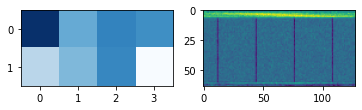

In [145]:
from tensorflow.keras.models import Model

index = 200
img = train_np[index,:,:,:]
img = np.expand_dims(img, axis=0)
inter_model = Model(model.input, model.get_layer('conv5_block3_3_conv').output)
inter_features = inter_model.predict(img)
print(img.shape, inter_features.shape)
inter_features_reshaped = np.reshape(inter_features, (7,7,2048))[:,:,50]

plt.figure(figsize=(30,20))
f, ax = plt.subplots(1,2)
ax[0].imshow(inter_features_reshaped, cmap=plt.cm.Blues_r)
ax[1].imshow(img[0,:,:,0])
plt.show()

In [227]:
label = 8
argmax_Y = (np.argmax(train_label, axis=1))
img_index = np.where(argmax_Y == label)[0]
selected_image = train_np[img_index,:,:,:]

argmax_Y = (np.argmax(val_label, axis=1))
img_index = np.where(argmax_Y == label)[0]
selected_img_val = val_np[img_index,:,:,:]

Text(0.5, 1.0, 'Attention Area')

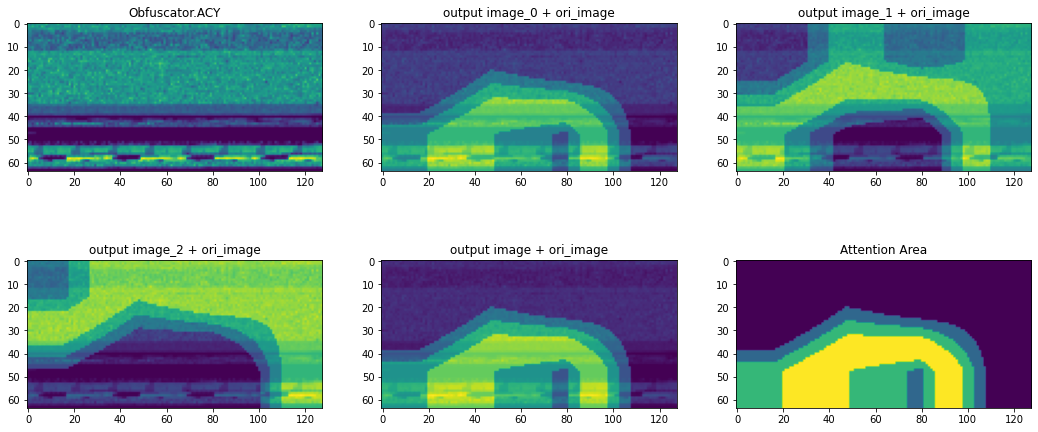

In [240]:
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image

LAYER_NAME = 'conv5_block3_3_conv'
index = 0
# def CAM(index):
# # Image to pass as input
img = np.zeros((224, 224, 3))
output =np.zeros((224, 224, 3))
result = np.zeros((224, 224, 3))

img = selected_image[index,:,:,:]
label = np.argmax(argmax_Y[index])
CLASS_INDEX = label

# Create a graph that outputs target convolution and output
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

# Get the score for target class
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CLASS_INDEX]

# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]
# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1))


# Build a ponderated map of filters according to gradients importance
cam = np.ones(output.shape[0:2], dtype=np.float32)

for index_weight, w in enumerate(weights):
    cam += w * output[:, :, index_weight]

# Heatmap visualization
cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(cv2.cvtColor((img).astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 0.01, 0)

alpha=0.6
f, ax = plt.subplots(2,3,figsize=(18,8)) 
img = selected_image[index,:,:,:]
# 원본이미지 그리기
ax[0][0].set_title(output_class(train_label[index]))
ax[0][0].imshow(img[:,:,0])

# output 이미지에 원본사진을 더해줌
output = output_image[:,:,0]
output = np.expand_dims(output, axis=2)
result=output*alpha+img
ax[0][1].set_title("output image_0 + ori_image")
ax[0][1].imshow(result[:,:,0])

# output 이미지에 원본사진을 더해줌
output = output_image[:,:,1]
output = np.expand_dims(output, axis=2)
result=output*alpha+img
ax[0][2].set_title("output image_1 + ori_image")
ax[0][2].imshow(result[:,:,0])

# output 이미지에 원본사진을 더해줌
output = output_image[:,:,2]
output = np.expand_dims(output, axis=2)
result=output*alpha+img
ax[1][0].set_title("output image_2 + ori_image")
ax[1][0].imshow(result[:,:,0])

# output 이미지에 원본사진을 더해줌
img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

result=output_image[:,:,0:1]+img[:,:,0:1,0]
#     interpolation='nearest'
ax[1][1].imshow(result[:,:,0])
ax[1][1].set_title("output image + ori_image")

#     interpolation='nearest'
ax[1][2].imshow(output_image[:,:,0])
ax[1][2].set_title("Attention Area")

# img.shape, output_image.shape, result.shape, output_image[:].shape

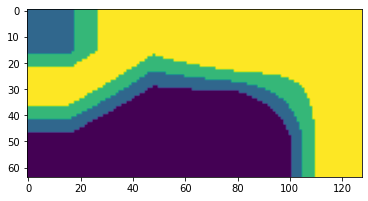

In [244]:
plt.imshow(output_image[:,:,2])

### 케이스 분석

In [102]:
val_np.shape, val_label.shape

((1087, 64, 128, 1), (1087, 10))

In [103]:
preds = model.predict(val_np)

In [104]:
model.evaluate(val_np,val_label)

34/34 [==============================] - 1s 19ms/step - loss: 0.2100 - accuracy: 0.9457


[0.2100471407175064, 0.9457221627235413]

In [105]:
index_list = []
for i in range(preds.shape[0]):
    if not(np.argmax(preds[i]) == np.argmax(val_label[i])):
        index_list.append(i)
index_list

[12,
 25,
 31,
 45,
 65,
 107,
 115,
 122,
 125,
 138,
 149,
 177,
 180,
 194,
 202,
 229,
 230,
 232,
 248,
 302,
 306,
 311,
 313,
 326,
 328,
 331,
 340,
 361,
 364,
 367,
 381,
 386,
 391,
 461,
 513,
 527,
 534,
 539,
 592,
 635,
 641,
 658,
 669,
 677,
 744,
 785,
 845,
 855,
 880,
 884,
 894,
 901,
 918,
 951,
 1000,
 1009,
 1010,
 1058,
 1074]

12  is  9 1


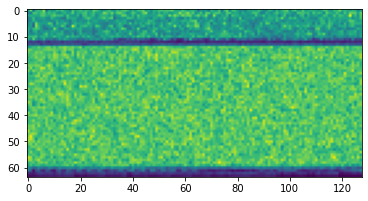

25  is  2 6


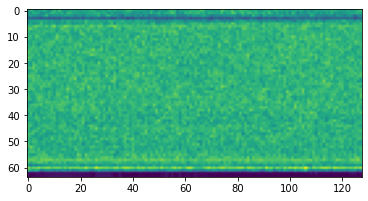

31  is  9 1


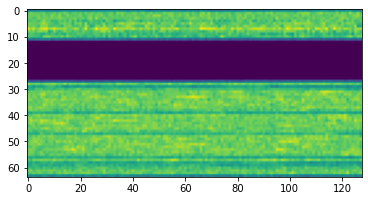

45  is  8 1


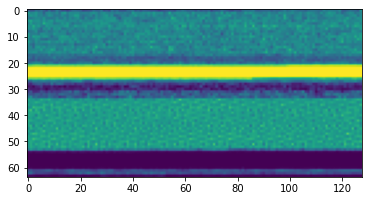

65  is  9 2


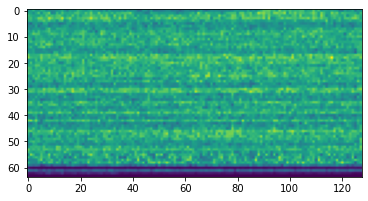

107  is  8 9


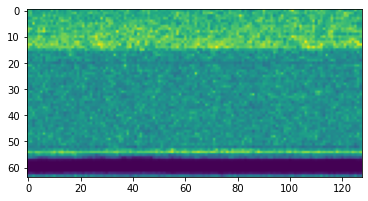

115  is  2 9


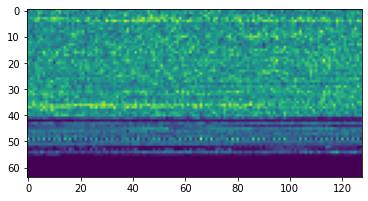

122  is  6 8


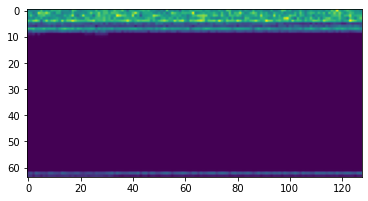

125  is  6 8


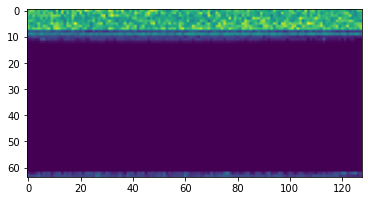

138  is  9 1


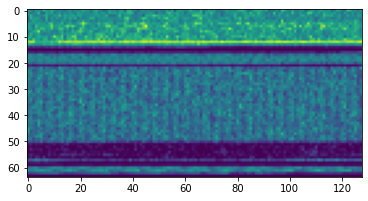

149  is  8 4


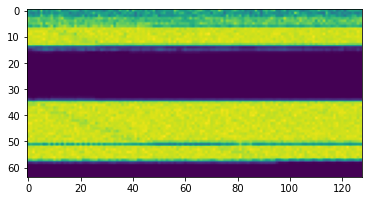

177  is  8 4


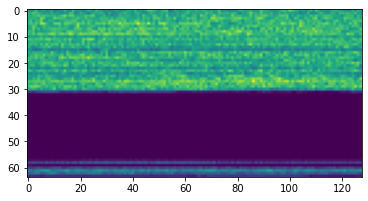

180  is  1 9


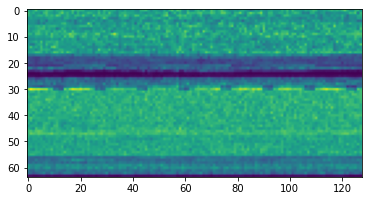

194  is  9 6


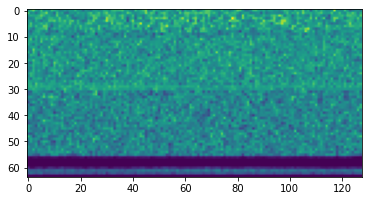

202  is  1 4


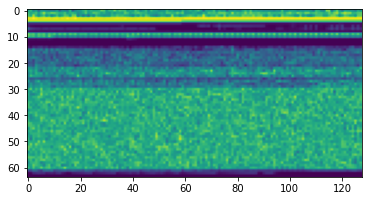

229  is  5 8


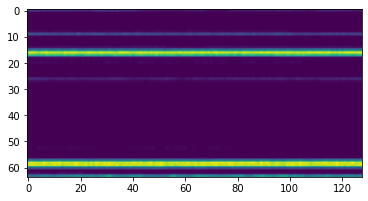

230  is  2 1


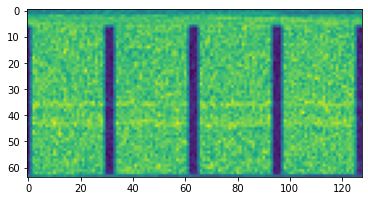

232  is  8 6


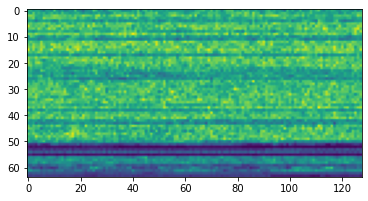

248  is  6 9


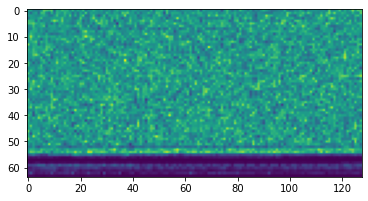

302  is  8 1


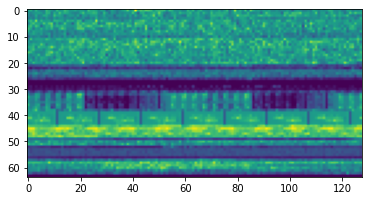

306  is  5 8


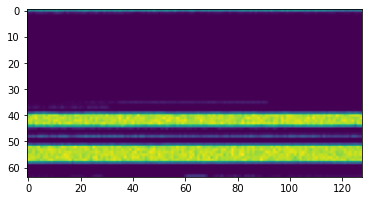

311  is  6 9


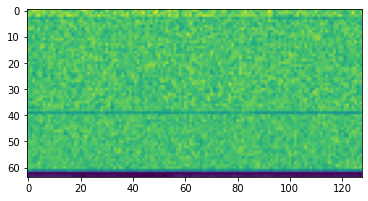

313  is  7 1


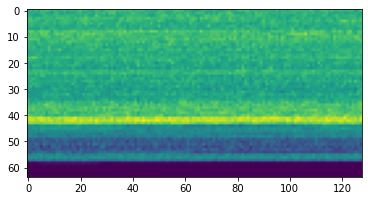

326  is  9 8


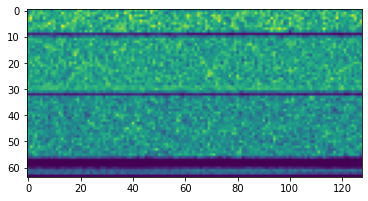

328  is  8 4


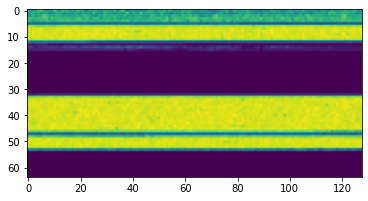

331  is  1 4


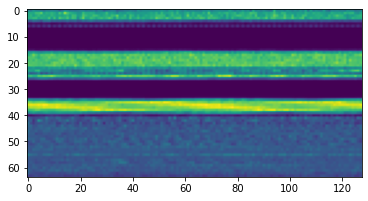

340  is  9 6


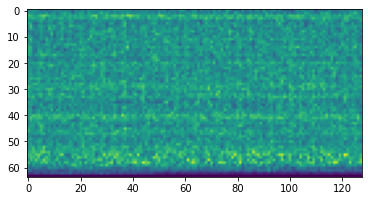

361  is  8 1


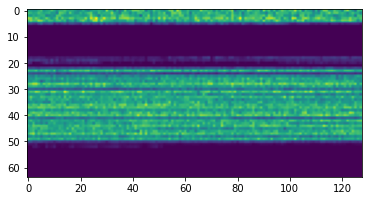

364  is  6 2


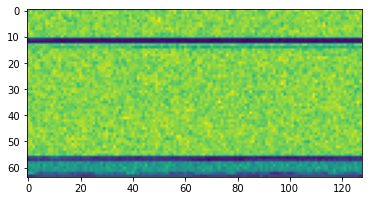

367  is  8 3


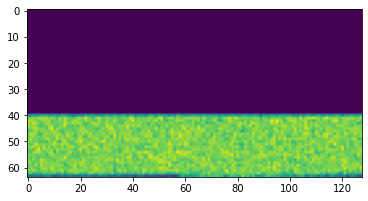

381  is  7 9


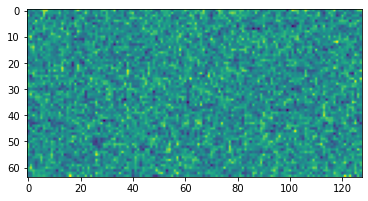

386  is  2 8


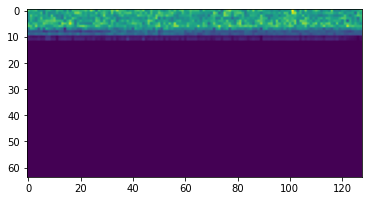

391  is  9 1


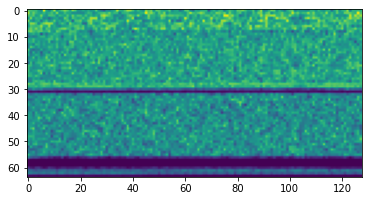

461  is  9 1


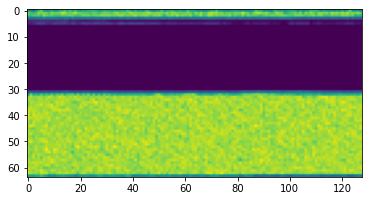

513  is  4 2


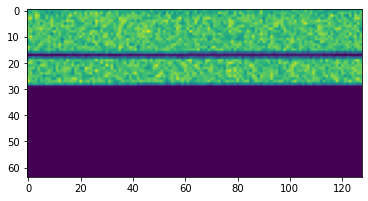

527  is  8 1


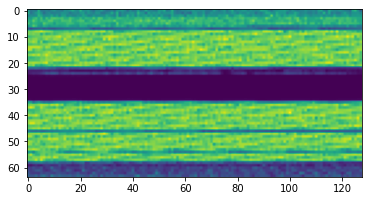

534  is  9 6


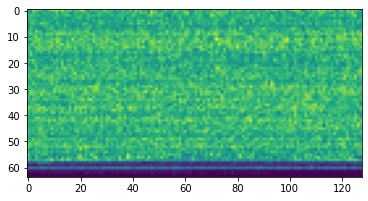

539  is  1 9


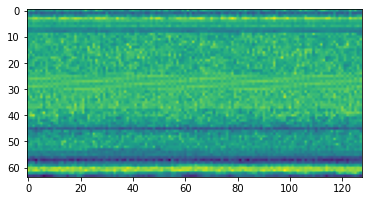

592  is  6 7


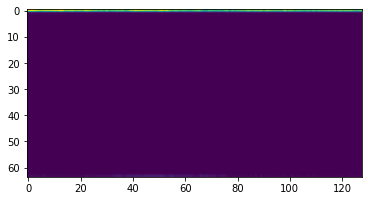

635  is  8 1


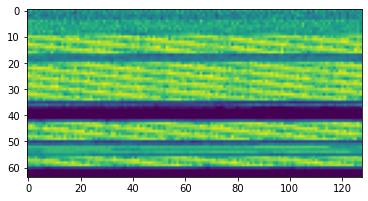

641  is  4 1


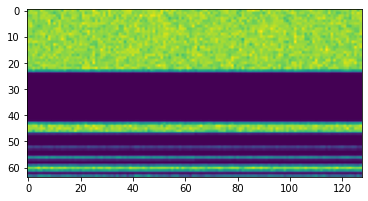

658  is  2 9


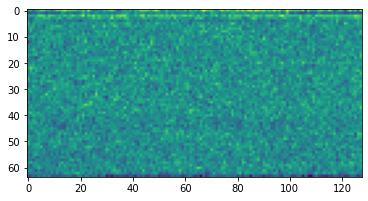

669  is  6 1


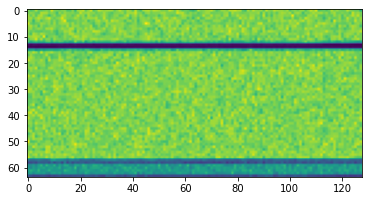

677  is  8 4


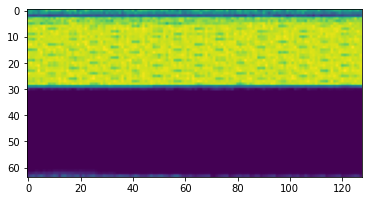

744  is  1 8


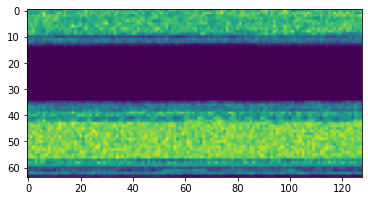

785  is  8 9


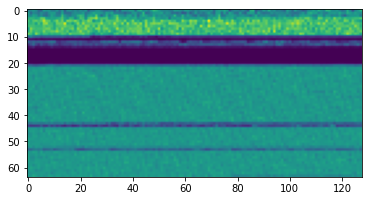

845  is  6 2


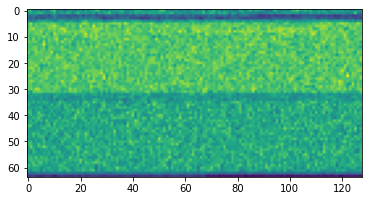

855  is  8 1


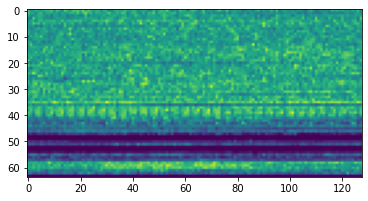

880  is  1 4


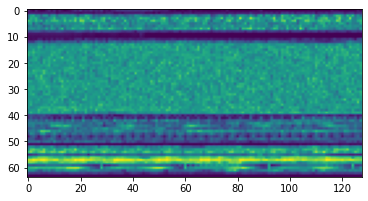

884  is  6 1


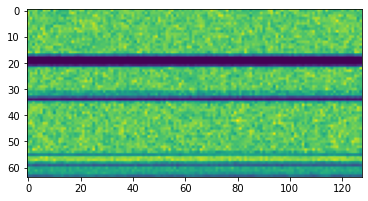

894  is  7 9


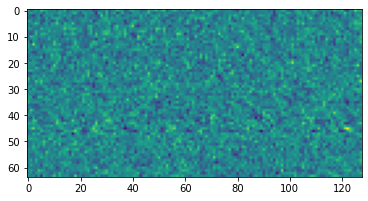

901  is  7 1


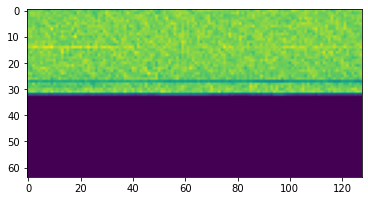

918  is  1 9


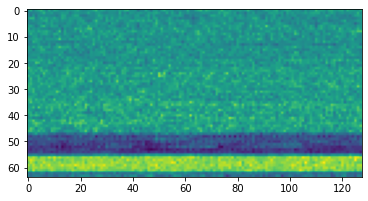

951  is  6 1


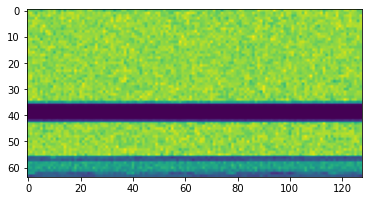

1000  is  4 9


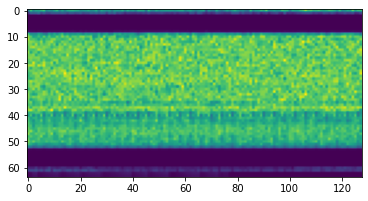

1009  is  3 9


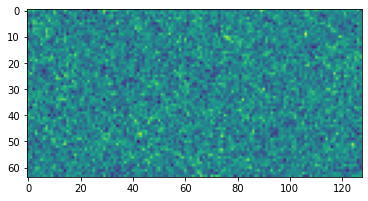

1010  is  8 9


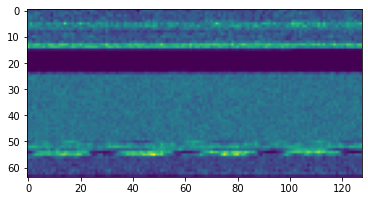

1058  is  1 7


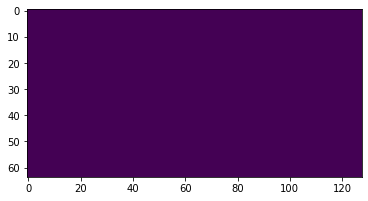

1074  is  1 6


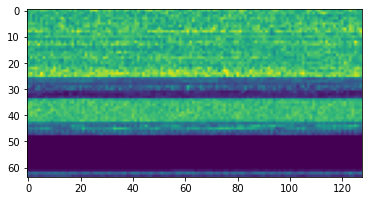

In [132]:
for i in range(len(index_list)):
    print(index_list[i]," is ",np.argmax(val_label[index_list][i]), np.argmax(preds[index_list[i]]) )
    plt.imshow(val_np[index_list][i,:,:,0])
    plt.show()

In [107]:
### 실제 어텐션이 잡고 있는것들

### ROC CURVE

In [108]:
lr_probs = model.predict(val_np)
lr_probs

array([[-3.0185125 ,  1.9326019 , -1.9341054 , ..., -1.1176559 ,
         2.2786024 , -2.2823672 ],
       [-3.0953298 , -0.24504851, -0.93474877, ..., -0.58225244,
         1.8936473 , -1.6990424 ],
       [-6.035172  , -1.4114376 ,  3.908902  , ...,  1.2732228 ,
         0.08265572,  9.599144  ],
       ...,
       [-3.2916768 ,  0.04103591, -2.891154  , ..., -0.90872943,
         0.28695095, -2.1678991 ],
       [-5.4590125 , -1.61483   ,  2.741443  , ...,  2.2222025 ,
         1.5022142 , 11.569719  ],
       [-4.30613   , -2.5800915 , 11.009397  , ...,  1.1544021 ,
         1.6268954 ,  4.6896214 ]], dtype=float32)

In [109]:
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
fpr = dict()
tpr = dict()
roc_auc = dict()
lr_probs = model.predict(val_np)
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(val_label[:, i], lr_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(val_label.ravel(), lr_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

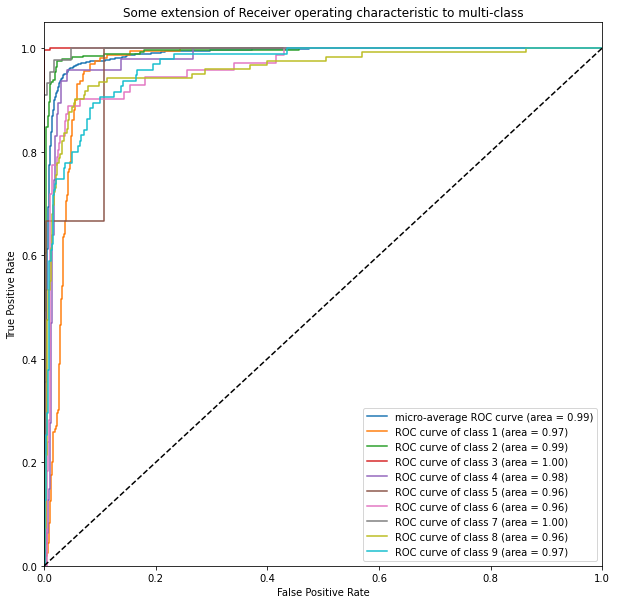

In [110]:
# Plot ROC curve
# plt.figure()
plt.figure(figsize = (10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(9):
    plt.plot(fpr[i+1], tpr[i+1], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i+1, roc_auc[i+1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [122]:
from sklearn.manifold import TSNE
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def scatter(x, labels, subtitle=None):
    palette = np.array(sns.color_palette("hls", 10))
    f = plt.figure(figsize=(20, 20))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], s=40, c=palette[labels.astype(np.int)],edgecolor='black')
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    txts = []
    for i in range(10):
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)
    if subtitle != None:
        plt.suptitle(subtitle)
    plt.savefig(subtitle)
def plot_history(model_input, mode='loss', title='Entropy'):
    history = model_input.history
    plt.plot(history.history[mode])
    plt.plot(history.history['val_'+mode])
    plt.title(title)
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()


n_visualization = 1024
tsne = TSNE()
X_train_trm = model.predict(train_np[:n_visualization])
X_test_trm = model.predict(val_np[:])
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


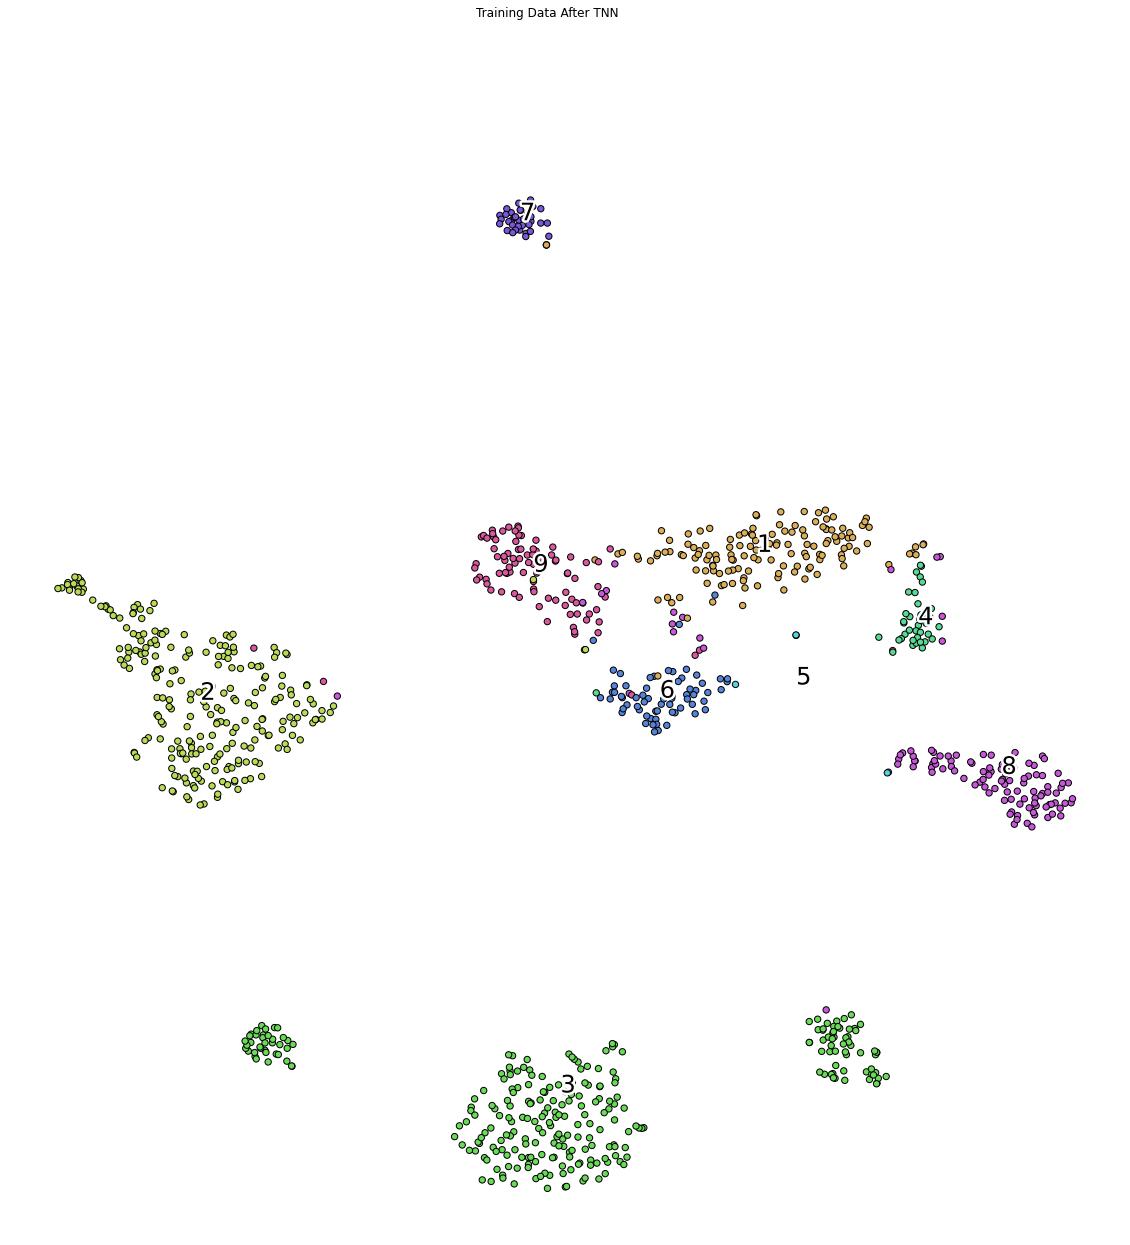

In [112]:
scatter(train_tsne_embeds, np.argmax(train_label[:n_visualization], axis=1), "Training Data After TNN")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


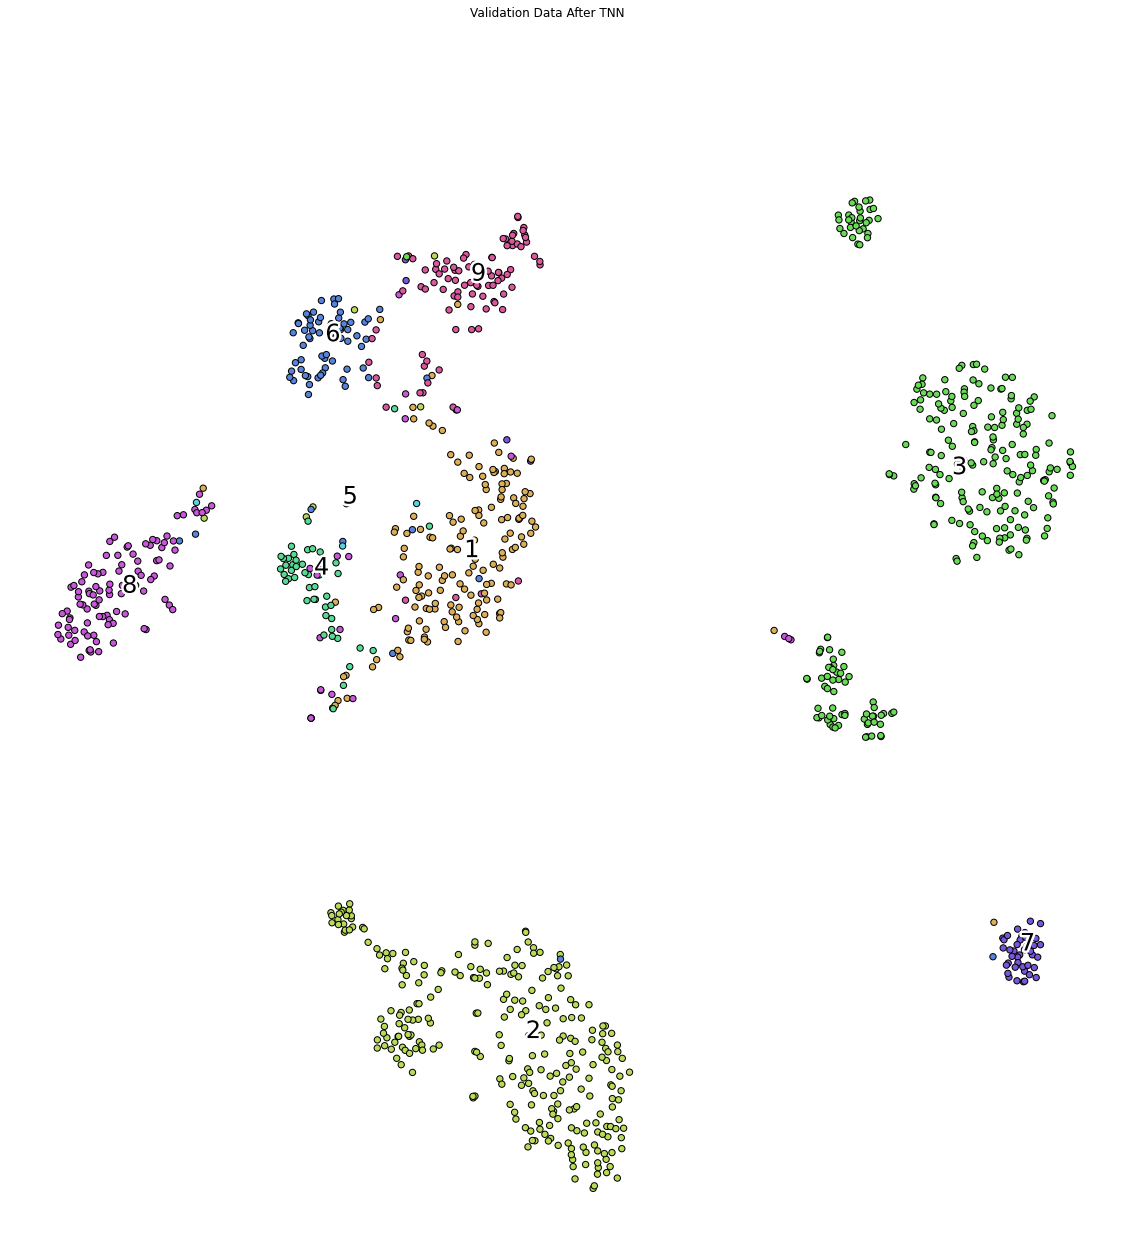

In [123]:
confusion_matrix

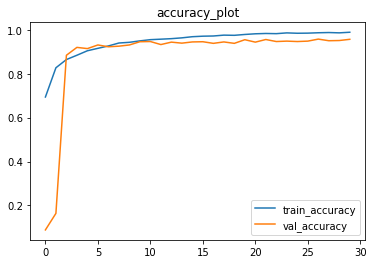

In [114]:
plt.plot(hist.history["accuracy"], label='train_accuracy')
plt.plot(hist.history["val_accuracy"], label='val_accuracy')
plt.title('accuracy_plot')
plt.legend()
plt.show()

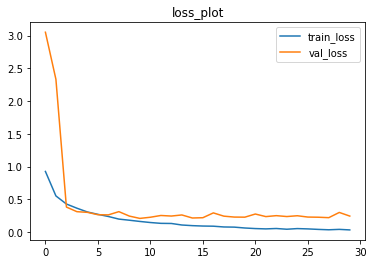

In [115]:
plt.plot(hist.history["loss"], label='train_loss')
plt.plot(hist.history["val_loss"], label='val_loss')
plt.title('loss_plot')
plt.legend()
plt.show()

In [116]:
from sklearn.metrics import confusion_matrix
import pandas as pd

y_pred = model.predict(val_np)    
y_true=pd.DataFrame(val_label).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)

In [117]:
conf_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred_classified))
conf_matrix

0   1    2    3    4    5  6   7   8
0  85   0    0    1    1    5  0   3   0
1   2  40    0    0    0    2  0   0   0
2   1   0  269    0    0    0  0   0   0
3   2   0    0  271    1    1  0   1   0
4   3   0    1    0  107    6  0   1   4
5   3   1    0    0    1  150  0   1   3
6   0   0    0    0    2    0  1   0   0
7   2   1    0    2    2    3  0  61   0
8   1   0    0    1    0    1  0   0  44

In [124]:
# Handcrafted function definition
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def wrapped_confusion_matrix(modelInput, feature, label, classInfo=["first", "second"]):
    pred = modelInput.predict(feature)
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(pred, axis=1))
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classInfo, normalize=False, title='')
    plt.show()

In [125]:
classInfo = ['Ramnit','Lollipop', 'Kelihos_ver3','Vundo','Simda', 'Tracur','Kelihos_ver1','Obfuscator.ACY','Gatak']


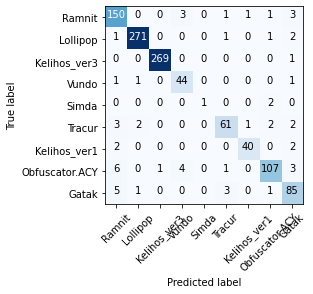

In [126]:
import itertools
wrapped_confusion_matrix(model, val_np, val_label, classInfo=classInfo)

In [32]:
model.evaluate(val_np,val_label)

85/85 [==============================] - 3s 30ms/step - loss: 0.5207 - accuracy: 0.8506


[0.5206738114356995, 0.8505704998970032]

In [36]:
from sklearn.metrics import recall_score

y_preds = model.predict(val_np)
np_y_preds = np.argmax(y_preds, axis=1)
Y_true =  np.argmax(val_label, axis=1)
result = recall_score(Y_true, np_y_preds, average='macro')
result

0.7224195976968949

In [14]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from tensorflow.keras.callbacks import EarlyStopping


# es = EarlyStopping(monitor='val_loss', patience=15, mode='auto', restore_best_weights=True)
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:1","/gpu:2","/gpu:3"])
# with mirrored_strategy.scope():
#     optimizer = tf.keras.optimizers.Adam(learning_rate)
#     model = ResNet101V2((img_size, img_size, 1),  dropout_rate=dropout_rate)
#     model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [68]:
'''BATCH_SIZE = 100
img_size = 224
#weights = None
weights = 'imagenet'
learning_rate = 1e-5
EPOCHS = 150
dropout_rate = 0.5
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:1","/gpu:2","/gpu:3"])
with mirrored_strategy.scope():
    # Generate a print
    kfold = KFold(n_splits=10, shuffle=True, random_state=42) 
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(X, Y):
        optimizer = tf.keras.optimizers.Adam(learning_rate)
        model = ResNet101V2((img_size, img_size, 1),  dropout_rate=dropout_rate)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

     # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        es = EarlyStopping(monitor='loss', patience=15, mode='auto', restore_best_weights=True)
        history = model.fit(X[train], Y[train],
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  callbacks=[es],
                  verbose=1)

        scores = model.evaluate(X[test], Y[test], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increase fold number
        fold_no = fold_no + 1'''

'BATCH_SIZE = 100\nimg_size = 224\n#weights = None\nweights = \'imagenet\'\nlearning_rate = 1e-5\nEPOCHS = 150\ndropout_rate = 0.5\n# Define per-fold score containers\nacc_per_fold = []\nloss_per_fold = []\n\nmirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:1","/gpu:2","/gpu:3"])\nwith mirrored_strategy.scope():\n    # Generate a print\n    kfold = KFold(n_splits=10, shuffle=True, random_state=42) \n    # K-fold Cross Validation model evaluation\n    fold_no = 1\n    for train, test in kfold.split(X, Y):\n        optimizer = tf.keras.optimizers.Adam(learning_rate)\n        model = ResNet101V2((img_size, img_size, 1),  dropout_rate=dropout_rate)\n        model.compile(loss=\'categorical_crossentropy\', optimizer=optimizer, metrics=[\'accuracy\'])\n\n     # Generate a print\n        print(\'------------------------------------------------------------------------\')\n        print(f\'Training for fold {fold_no} ...\')\n\n        es = EarlyStopping(monitor=\'loss\', patien

In [16]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')



------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.7024705410003662 - Accuracy: 87.67249584197998%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.9363585710525513 - Accuracy: 87.58049607276917%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.8671115636825562 - Accuracy: 87.02852129936218%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.9364606142044067 - Accuracy: 84.45262312889099%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8922174572944641 - Accuracy: 86.75252795219421%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.8288220763206482 - Accuracy: 88.04047703742981%
------------------------------------------------------------------------

In [106]:
# import tensorflow as tf
# from tensorflow import keras
# model = keras.models.load_model("./ResNet101V2.h5")